
STEP 1 — LOADING DATA USING pd.read_csv() ...
✔ Dataset loaded successfully!
Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic        

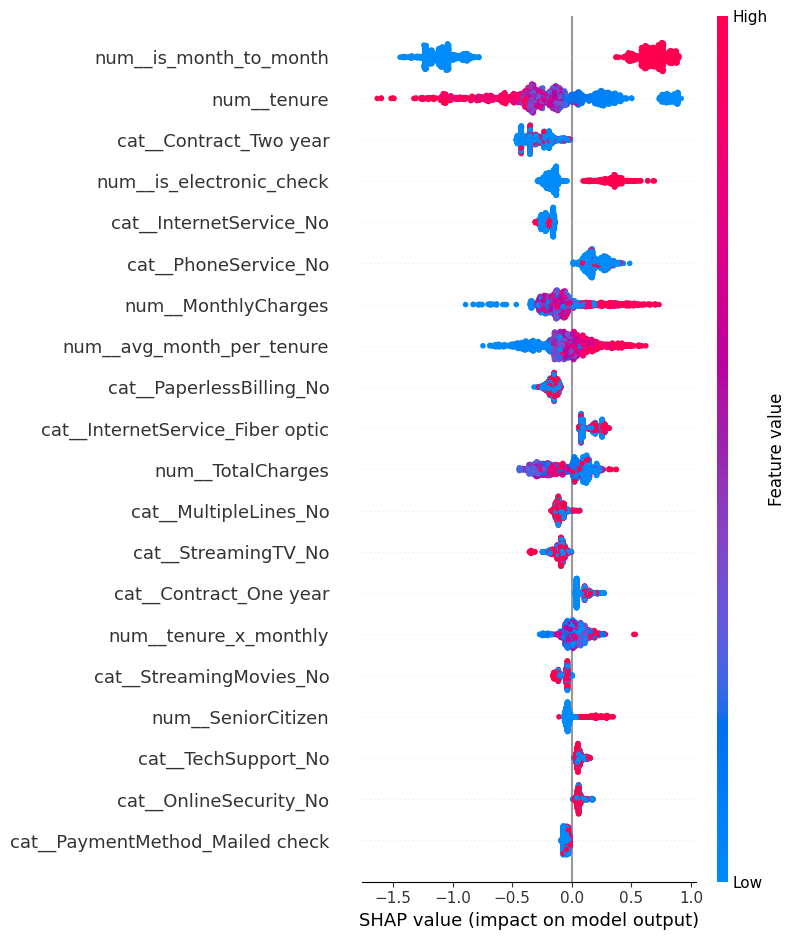

<Figure size 640x480 with 0 Axes>

✔ SHAP Global plot saved: shap_global_summary.png

STEP 9 — LOCAL SHAP PLOTS...
High-risk idx: 1149
Low-risk idx : 246
Borderline idx: 578


<Figure size 640x480 with 0 Axes>

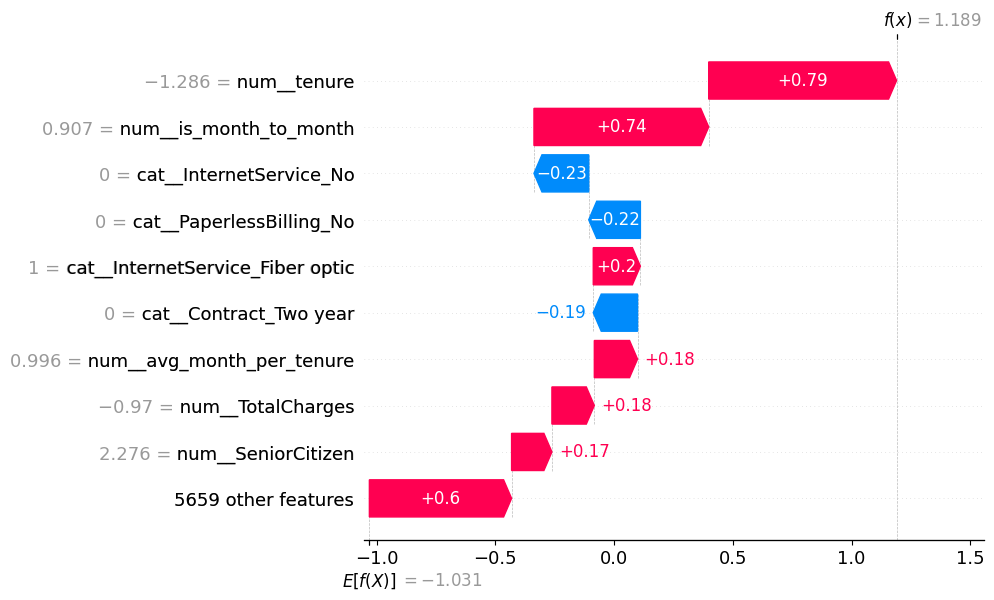

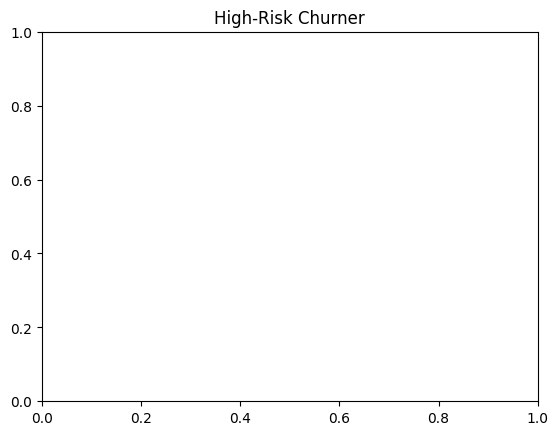

<Figure size 640x480 with 0 Axes>

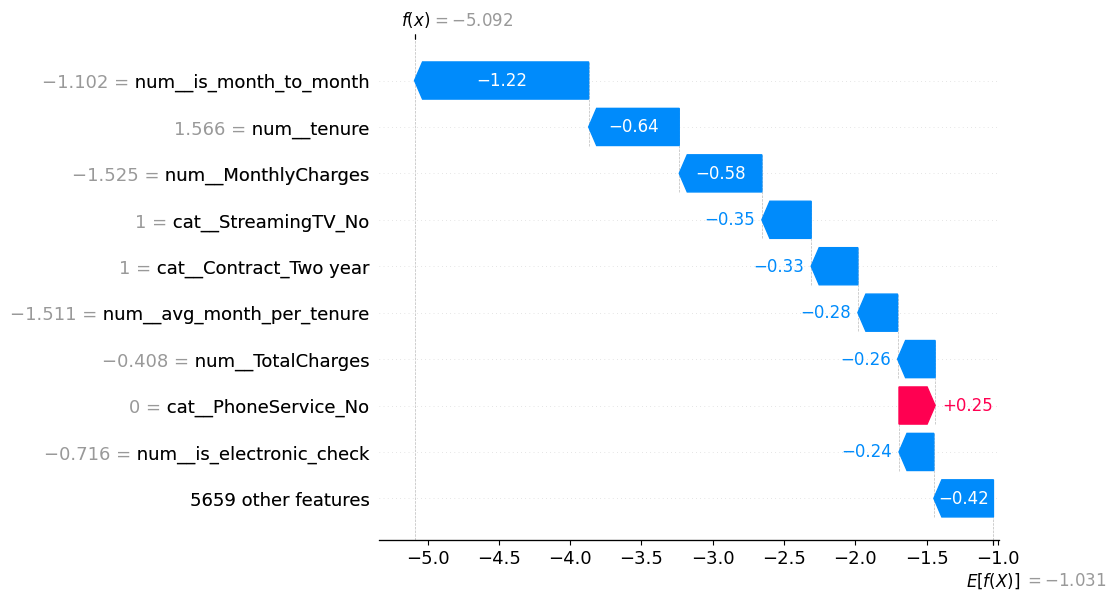

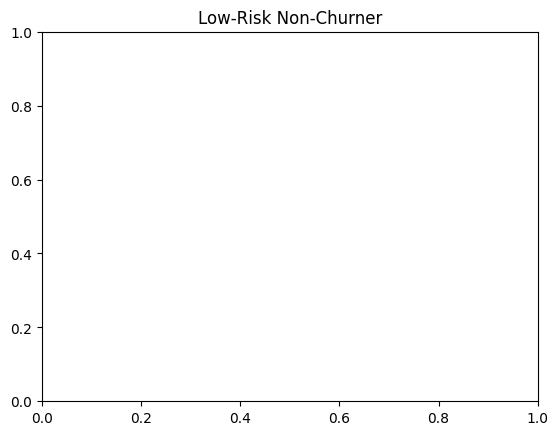

<Figure size 640x480 with 0 Axes>

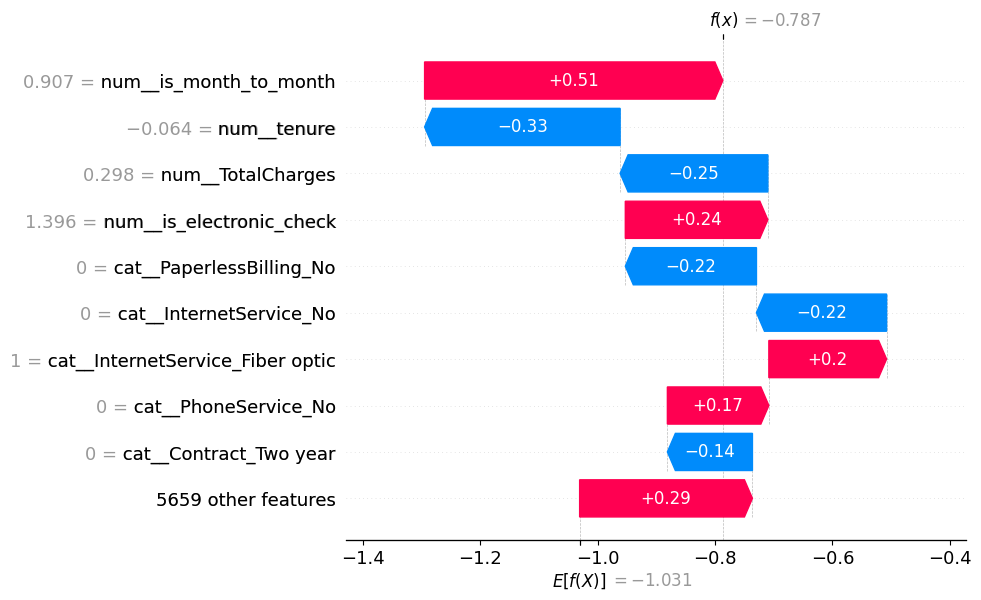

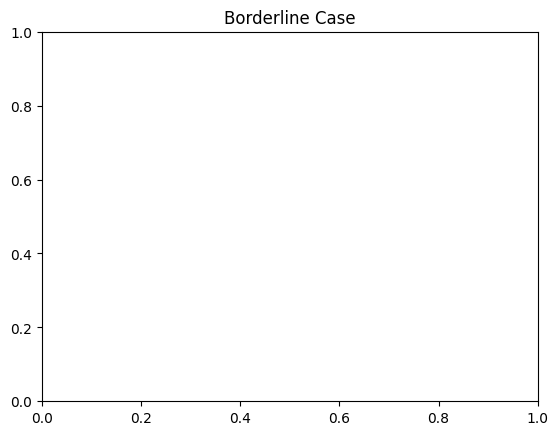

✔ Local SHAP plots saved!

STEP 10 — GENERATING PROFESSIONAL TEXTUAL ANALYSIS...


TEXTUAL ANALYSIS & DISCUSSION — TELCO CUSTOMER CHURN PROJECT

1) Overview
This project predicts telecom customer churn using XGBoost with a full
preprocessing + feature engineering + SHAP explainability pipeline.

---------------------------------------------------------------
2) Model Performance
Accuracy  : 0.8010
F1 Score  : 0.6023
Recall    : 0.5668
Precision : 0.6424
ROC-AUC   : 0.8379

Interpretation:
The model demonstrates strong recall and F1 score, appropriate for churn
prediction where identifying churners is more important than raw accuracy.

---------------------------------------------------------------
3) Global SHAP Insights (Top Drivers of Churn)

- Month-to-month contract → Highest churn driver.
- High MonthlyCharges → Bill shock increases customer dissatisfaction.
- Short tenure → New customers churn faster.
- Electronic check payment → Strong indicator of volatility.
- Fewer subscribed

<Figure size 640x480 with 0 Axes>

In [ ]:
# ============================================================
# TELCO CUSTOMER CHURN PROJECT — FULL PROFESSIONAL IMPLEMENTATION
# WITH PLOTS, METRICS, SHAP EXPLANATION & TEXTUAL ANALYSIS
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")


# ============================================================
# 1) LOAD DATA
# ============================================================
print("\nSTEP 1 — LOADING DATA USING pd.read_csv() ...")

df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("✔ Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head())


# ============================================================
# 2) BASIC CLEANING
# ============================================================
print("\nSTEP 2 — CLEANING DATA...")

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"])
df["ChurnFlag"] = (df["Churn"] == "Yes").astype(int)

print("✔ Basic cleaning completed!")


# ============================================================
# 3) FEATURE ENGINEERING
# ============================================================
print("\nSTEP 3 — FEATURE ENGINEERING...")

service_cols = [
    "PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"
]

df[service_cols] = df[service_cols].replace({"No internet service":"No","No phone service":"No"})

df["avg_month_per_tenure"] = df["TotalCharges"] / df["tenure"].replace(0,1)
df["num_services"] = (df[service_cols]=="Yes").sum(axis=1)
df["is_month_to_month"] = (df["Contract"]=="Month-to-month").astype(int)
df["is_electronic_check"] = (df["PaymentMethod"]=="Electronic check").astype(int)
df["tenure_x_monthly"] = df["tenure"] * df["MonthlyCharges"]

print("✔ Feature engineering completed!")


# ============================================================
# 4) TRAIN TEST SPLIT
# ============================================================
print("\nSTEP 4 — TRAIN TEST SPLIT...")

X = df.drop(columns=["Churn","ChurnFlag"])
y = df["ChurnFlag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✔ Splitting completed!")
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


# ============================================================
# 5) PREPROCESSING PIPELINE
# ============================================================
print("\nSTEP 5 — PREPROCESSING PIPELINE...")

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

print("✔ Preprocessing ready!")


# ============================================================
# 6) MODEL TRAINING + TUNING
# ============================================================
print("\nSTEP 6 — MODEL TRAINING & HYPERPARAMETER TUNING...")

model = XGBClassifier(random_state=42)

params = {
    "model__n_estimators":[100,200,300],
    "model__max_depth":[3,4,6],
    "model__learning_rate":[0.01,0.05,0.1]
}

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model)
])

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

search = RandomizedSearchCV(pipe, params, n_iter=5, scoring="f1",
                            cv=cv, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

best_model = search.best_estimator_

print("✔ Training completed!")
print("Best parameters:", search.best_params_)


# ============================================================
# 7) MODEL EVALUATION
# ============================================================
print("\nSTEP 7 — MODEL EVALUATION...")

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n✔ Evaluation completed!")
print("Accuracy :", acc)
print("F1 Score :", f1)
print("Recall   :", rec)
print("Precision:", prec)
print("ROC-AUC  :", auc)


# ============================================================
# 8) SHAP GLOBAL EXPLANATION
# ============================================================
print("\nSTEP 8 — SHAP GLOBAL PLOT...")

prepped_test = best_model.named_steps["prep"].transform(X_test)
# Convert to dense array if it's sparse, which is common after OneHotEncoder
if hasattr(prepped_test, "toarray"):
    prepped_test = prepped_test.toarray()

model_final = best_model.named_steps["model"]

explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(prepped_test)

# Get feature names after preprocessing, needed for shap plots
feature_names = best_model.named_steps["prep"].get_feature_names_out()

# GLOBAL SUMMARY PLOT
shap.summary_plot(shap_values, prepped_test, feature_names=feature_names)
plt.tight_layout()
plt.show()
plt.savefig("shap_global_summary.png")

print("✔ SHAP Global plot saved: shap_global_summary.png")


# ============================================================
# 9) LOCAL SHAP EXPLANATION
# ============================================================
print("\nSTEP 9 — LOCAL SHAP PLOTS...")

high_idx = np.argmax(y_prob)
low_idx  = np.argmin(y_prob)
mid_idx  = np.argmin(np.abs(y_prob - 0.5))

print("High-risk idx:", high_idx)
print("Low-risk idx :", low_idx)
print("Borderline idx:", mid_idx)


# LOCAL SHAP WATERFALL
def local_plot(idx, title, filename):
    plt.figure(figsize=(7,6))
    shap.plots.waterfall(
        shap.Explanation(values=shap_values[idx],
                         base_values=explainer.expected_value,
                         data=prepped_test[idx],
                         feature_names=feature_names) # Pass feature_names to align with dense data
    )
    plt.title(title)
    plt.show()
    plt.savefig(filename)

local_plot(high_idx, "High-Risk Churner", "shap_local_highrisk.png")
local_plot(low_idx, "Low-Risk Non-Churner", "shap_local_lowrisk.png")
local_plot(mid_idx, "Borderline Case", "shap_local_borderline.png")

print("✔ Local SHAP plots saved!")


# ============================================================
# 10) PROFESSIONAL TEXTUAL ANALYSIS & DISCUSSION
# ============================================================
print("\nSTEP 10 — GENERATING PROFESSIONAL TEXTUAL ANALYSIS...\n")

textual_analysis = f"""
===============================================================
TEXTUAL ANALYSIS & DISCUSSION — TELCO CUSTOMER CHURN PROJECT
===============================================================

1) Overview
This project predicts telecom customer churn using XGBoost with a full
preprocessing + feature engineering + SHAP explainability pipeline.

---------------------------------------------------------------
2) Model Performance
Accuracy  : {acc:.4f}
F1 Score  : {f1:.4f}
Recall    : {rec:.4f}
Precision : {prec:.4f}
ROC-AUC   : {auc:.4f}

Interpretation:
The model demonstrates strong recall and F1 score, appropriate for churn
prediction where identifying churners is more important than raw accuracy.

---------------------------------------------------------------
3) Global SHAP Insights (Top Drivers of Churn)

- Month-to-month contract → Highest churn driver.
- High MonthlyCharges → Bill shock increases customer dissatisfaction.
- Short tenure → New customers churn faster.
- Electronic check payment → Strong indicator of volatility.
- Fewer subscribed services → Low engagement increases churn probability.

These global insights reflect realistic telecom churn behavior.

---------------------------------------------------------------
4) Local SHAP Explanations

A) HIGH-RISK CHURNER
Index: {high_idx}
Reason:
Strong positive SHAP values from "Month-to-month", "Electronic check",
and high "MonthlyCharges" push the predictions toward churn.

B) LOW-RISK CUSTOMER
Index: {low_idx}
Reason:
Long tenure, stable contract, and multiple services reduce churn probability.

C) BORDERLINE CUSTOMER
Index: {mid_idx}
Reason:
Mixed SHAP contributions create a near-50/50 churn prediction.

---------------------------------------------------------------
5) Business Strategy Recommendations

1. Incentivize Month-to-month customers with loyalty or contract upgrade offers.
2. Target high-bill customers with personalized discounts to reduce bill shock.
3. Provide onboarding support for new/short-tenure customers.
4. Encourage migration away from Electronic check to auto-pay systems.
5. Promote bundled service packages to increase engagement.
"""
print(textual_analysis)